##Finally apply the best model on Test data!


#Install Libraries

In [1]:
pip install dask[dataframe]

     |████████████████████████████████| 118 kB 4.2 MB/s 


In [2]:
pip install biosppy

     |████████████████████████████████| 85 kB 2.2 MB/s 
  Created wheel for biosppy: filename=biosppy-0.7.3-py2.py3-none-any.whl size=95429 sha256=908504056537452173a6bdd0f003488ffa0b6077ba12f86b79838e46b9b85055
  Stored in directory: /root/.cache/pip/wheels/2f/4f/8f/28b2adc462d7e37245507324f4817ce1c64ef2464f099f4f0b
Successfully built biosppy


In [3]:
import numpy as np
import pandas as pd
import dask
#import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
#Use the Biosppy module to derive features from the   data
#from biosppy.signals import ecg, resp,eeg
from scipy.interpolate import interp1d
#Use Dask to work with the huge dataset. 
import dask
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder
import warnings
warnings. filterwarnings("ignore")
from sklearn.metrics import log_loss
import joblib
from sklearn.externals import joblib  

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Fetch the test data from Kaggle

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1627929779&Signature=JyYfYwTok3zYi5DGUadp8ClK%2BRPhYh%2BR%2FokY0RXhXNIv%2FASfVHHrDdGuVI15IannhfS2tESXGLeuSlAXackcTBGcAB0d2d8iXUyB2uJgjvR%2BOX9kiPjvpn%2FQe4XS6TnpFOYT1tTLoQR04t%2F30XNgq%2FlDImljhY%2FGGH4NDAuN3RQ0SKYNwvYITeqTGeIpoe786TWnuDoDuVK9NpMhWOOua3IAcmXhvOSlZrbRNx3MXE6Sx6XCeRA94Qt%2FQsh49U6B%2BPQFhDiWgNh9D07HLN%2BjKD2Fh8ZQpx2IwErGHVqZX79vzWS2BcpWAEGUpm%2BVC9ehnTeyDeWSOrEC3MjsByGt2A%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip" -c -O 'test.csv.zip'

--2021-07-31 15:06:39--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/11835/224935/compressed/test.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1627929779&Signature=JyYfYwTok3zYi5DGUadp8ClK%2BRPhYh%2BR%2FokY0RXhXNIv%2FASfVHHrDdGuVI15IannhfS2tESXGLeuSlAXackcTBGcAB0d2d8iXUyB2uJgjvR%2BOX9kiPjvpn%2FQe4XS6TnpFOYT1tTLoQR04t%2F30XNgq%2FlDImljhY%2FGGH4NDAuN3RQ0SKYNwvYITeqTGeIpoe786TWnuDoDuVK9NpMhWOOua3IAcmXhvOSlZrbRNx3MXE6Sx6XCeRA94Qt%2FQsh49U6B%2BPQFhDiWgNh9D07HLN%2BjKD2Fh8ZQpx2IwErGHVqZX79vzWS2BcpWAEGUpm%2BVC9ehnTeyDeWSOrEC3MjsByGt2A%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to d

In [ ]:
!unzip /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [ ]:
test_df = pd.read_csv('/content/test.csv')


In [32]:
#https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category',ordered=True,)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


In [ ]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,-187.080002,-33.183498,-4.220780,8.178160,33.160301,33.812500,21.744699,16.293800,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,-5.145290,6.395940,33.420101,-295.013000,8.373170,29.636400,16.223000,850.288025,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,-107.236000,12.845200,1.215280,13.317000,44.435101,37.585800,29.073000,22.316099,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,-8.021180,7.427430,27.345699,-310.165009,5.389070,27.733999,7.217500,816.679016,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,37.007900,-50.334202,-11.676400,-1.143860,-17.600500,34.075600,22.912399,19.033800,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [ ]:
test_df.isnull().sum()

id            0
crew          0
experiment    0
time          0
seat          0
eeg_fp1       0
eeg_f7        0
eeg_f8        0
eeg_t4        0
eeg_t6        0
eeg_t5        0
eeg_t3        0
eeg_fp2       0
eeg_o1        0
eeg_p3        0
eeg_pz        0
eeg_f3        0
eeg_fz        0
eeg_f4        0
eeg_c4        0
eeg_p4        0
eeg_poz       0
eeg_c3        0
eeg_cz        0
eeg_o2        0
ecg           0
r             0
gsr           0
dtype: int64

##Feature Engineering

In [ ]:
#This function denoises the rawdata using a Butterworth filter
def denoise(frequency,raw_data,filter_order):

  #Use the Butterworth filter to filter noise. This filter filters out the noise. Noise is the data which is beyond the typical frequency of the sensory data.
  b, a = signal.butter(filter_order,frequency)

  y = signal.filtfilt(b, a, raw_data, padlen=150)

  return y

def interpolation_fn(timestamps,biosppy_timestamps, biosppy_values):

    interpolation = interp1d(biosppy_timestamps,biosppy_values, kind="linear", fill_value="extrapolate") 
    return interpolation(timestamps)

In [ ]:
#Interpolation for the different frequencies from EEG data - theta, alpha_low, alpha_high
def get_eeg_features(feature_key,arr_size,new_feature_df, tsArr, featureArr):

  output = []

  for i in range(arr_size):
    feature_name = "egg_"+ feature_key + str(i)    
    new_feature_df[feature_name] = interpolation_fn(test_df["time"],tsArr,featureArr[:,i])

In [ ]:
#Denoising Respiration rate,ECG.
#Apply interpolation on the denoised data to obtain data for the entire time series

denoised_r = denoise(0.05,test_df["r"],5) 
test_df['denoised_r'] = denoised_r

resp_rate_op = resp.resp(test_df['denoised_r'],sampling_rate=256, show=False)
resp_rate_arr = interpolation_fn(test_df["time"],resp_rate_op['resp_rate_ts'],resp_rate_op['resp_rate'])
test_df['r_rate'] =resp_rate_arr

denoised_ecg = denoise(0.05,test_df["ecg"],5) 
test_df['denoised_ecg'] = denoised_ecg

test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/test1.csv')

heart_rate_op = ecg.ecg(signal=test_df['denoised_ecg'], sampling_rate=256, show=False)
heart_rate_arr = interpolation_fn(test_df["time"],heart_rate_op['heart_rate_ts'],heart_rate_op['heart_rate'])
test_df['heart_rate'] =heart_rate_arr

np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/heart_rate',heart_rate_arr)

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/test1.csv')
test_df['heart_rate']  = np.load('/content/drive/MyDrive/Colab Notebooks/Aviation/heart_rate.npy')

In [ ]:
#Drop the columns that are no longer required like the noise filled ecg, respiration. Experiment and id also can be removed.
test_df.drop(['experiment','ecg','r','id','Unnamed: 0'],inplace=True,axis = 1)

In [ ]:
#Information is extracted from the raw EEG data by combining the values of corresponding electrode readings. 
test_df['fp1_f7'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f7_t3'] = test_df['eeg_f7'] - test_df['eeg_t3']
test_df['t3_t5'] = test_df['eeg_t3'] - test_df['eeg_t5']
test_df['t5_o1'] = test_df['eeg_t5'] - test_df['eeg_o1']
test_df['fp1_f3'] = test_df['eeg_fp1'] - test_df['eeg_f7']
test_df['f3_c3'] = test_df['eeg_f3'] - test_df['eeg_c3']
test_df['c3_p3'] = test_df['eeg_c3'] - test_df['eeg_p3']
test_df['p3_o1'] = test_df['eeg_p3'] - test_df['eeg_o1']

test_df['fz_cz'] = test_df['eeg_fz'] - test_df['eeg_cz']
test_df['cz_pz'] = test_df['eeg_cz'] - test_df['eeg_pz']
test_df['pz_poz'] = test_df['eeg_pz'] - test_df['eeg_poz']

test_df['fp2_f8'] = test_df['eeg_fp2'] - test_df['eeg_f8']
test_df['f8_t4'] = test_df['eeg_f8'] - test_df['eeg_t4']
test_df['t4_t6'] = test_df['eeg_t4'] - test_df['eeg_t6']
test_df['t6_o2'] = test_df['eeg_t6'] - test_df['eeg_o2']
test_df['fp2_f4'] = test_df['eeg_fp2'] - test_df['eeg_f4']
test_df['f4_c4'] = test_df['eeg_f4'] - test_df['eeg_c4']
test_df['c4_p4'] = test_df['eeg_c4'] - test_df['eeg_p4']
test_df['p4_o2'] = test_df['eeg_p4'] - test_df['eeg_o2']

eeg_feature_names = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]


In [ ]:
test_df.head()

,Unnamed: 0,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,denoised_r,denoised_ecg,r_rate,heart_rate
0,0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,-187.080002,-33.183498,-4.220780,8.178160,33.160301,33.812500,21.744699,16.293800,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992,643.165290,-7323.369624,0.087332,-3992.664385
1,1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,-5.145290,6.395940,33.420101,-295.013000,8.373170,29.636400,16.223000,850.288025,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001,652.494487,-7121.141194,0.087332,-3992.664385
2,2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,-107.236000,12.845200,1.215280,13.317000,44.435101,37.585800,29.073000,22.316099,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992,661.736179,-6920.799969,0.087340,-3992.637877
3,3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,-8.021180,7.427430,27.345699,-310.165009,5.389070,27.733999,7.217500,816.679016,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001,670.804441,-6724.199018,0.087340,-3992.637877
4,4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,37.007900,-50.334202,-11.676400,-1.143860,-17.600500,34.075600,22.912399,19.033800,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992,679.616767,-6533.117651,0.087347,-3992.611369


In [ ]:
#Identifies different frequencies from the EEG data and extracts the same. - theta, alpha_low, alpha_high
eeg_freq_arr = eeg.get_power_features(test_df[eeg_feature_names],sampling_rate=256)
get_eeg_features('theta',20,test_df,tsArr,thetaArr)
get_eeg_features('alpha_low',20,test_df,tsArr,a_lowArr)
get_eeg_features('alpha_high',20,test_df,tsArr,a_highArr)

np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/ts',eeg_freq_arr['ts'])
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/theta',eeg_freq_arr['theta'])
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/alpha_low',eeg_freq_arr['alpha_low'])
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/alpha_high',eeg_freq_arr['alpha_high'])

In [ ]:
#Individual EEG readings combined to form more meaningful EEG data, hence the individual readings can be removed.
test_df.drop(["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"],inplace=True,axis=1)

In [ ]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 3700.71 MB
Memory usage after optimization is: 890.91 MB
Decreased by 75.9%


In [ ]:
tsArr = np.load('/content/drive/MyDrive/Colab Notebooks/Aviation/ts.npy')
thetaArr = np.load('/content/drive/MyDrive/Colab Notebooks/Aviation/theta.npy')
a_lowArr = np.load('/content/drive/MyDrive/Colab Notebooks/Aviation/alpha_low.npy')
a_highArr = np.load('/content/drive/MyDrive/Colab Notebooks/Aviation/alpha_high.npy')

#Get the rolling mean and min-max values from a window of 4 for GSR
gsr_mean = test_df['gsr'].rolling(window=4,min_periods=1).mean()
gsr_max = test_df['gsr'].rolling(window=4,min_periods=1).max()
gsr_min = test_df['gsr'].rolling(window=4,min_periods=1).min()

gsr_min_max = gsr_max - gsr_min

test_df['gsr_mean'] = gsr_mean
test_df['gsr_min_max'] = gsr_min_max
test_df = reduce_mem_usage(test_df)

#Write the entire test data to the drive.
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_test100.csv')

Memory usage of dataframe is 9388.83 MB
Memory usage after optimization is: 3015.39 MB
Decreased by 67.9%


In [ ]:
test_df.shape

(17965143, 89)

In [ ]:
test_df.head()

,crew,time,seat,gsr,denoised_r,denoised_ecg,r_rate,fp1_f7,f7_t3,t3_t5,t5_o1,fp1_f3,f3_c3,c3_p3,p3_o1,fz_cz,cz_pz,pz_poz,fp2_f8,f8_t4,t4_t6,t6_o2,fp2_f4,f4_c4,c4_p4,p4_o2,egg_theta0,egg_theta1,egg_theta2,egg_theta3,egg_theta4,egg_theta5,egg_theta6,egg_theta7,egg_theta8,egg_theta9,egg_theta10,egg_theta11,egg_theta12,egg_theta13,...,egg_alpha_low2,egg_alpha_low3,egg_alpha_low4,egg_alpha_low5,egg_alpha_low6,egg_alpha_low7,egg_alpha_low8,egg_alpha_low9,egg_alpha_low10,egg_alpha_low11,egg_alpha_low12,egg_alpha_low13,egg_alpha_low14,egg_alpha_low15,egg_alpha_low16,egg_alpha_low17,egg_alpha_low18,egg_alpha_low19,egg_alpha_high0,egg_alpha_high1,egg_alpha_high2,egg_alpha_high3,egg_alpha_high4,egg_alpha_high5,egg_alpha_high6,egg_alpha_high7,egg_alpha_high8,egg_alpha_high9,egg_alpha_high10,egg_alpha_high11,egg_alpha_high12,egg_alpha_high13,egg_alpha_high14,egg_alpha_high15,egg_alpha_high16,egg_alpha_high17,egg_alpha_high18,egg_alpha_high19,gsr_mean,gsr_min_max
0,1,0.000000,0,595.00,643.0,-7324.0,0.087341,11.773438,39.312500,153.875000,-195.25000,11.773438,-10.093750,-1.322266,24.984375,-0.781738,-16.734375,34.218750,-5.214844,29.203125,19.484375,-39.562500,2.824219,7.359375,-10.375000,4.101562,0.061299,0.459225,0.080141,0.125719,0.083603,0.260365,0.029180,0.109553,8.319673,0.007791,0.117237,0.059010,12.735767,0.047732,...,0.020916,0.011736,0.003388,0.024096,0.000324,0.030423,0.036097,0.017463,0.002928,0.050241,0.196383,0.046295,0.077565,0.018096,0.011206,0.030761,0.236543,0.385489,0.006375,0.000903,0.013874,0.015231,0.003157,0.039873,0.006004,0.011281,0.023168,0.012280,0.010506,0.035549,0.012451,0.005240,0.004161,0.017234,0.006565,0.015133,0.046671,0.049792,595.000000,0.00
1,1,0.000000,1,136.25,652.5,-7120.0,0.087341,-48.875000,88.375000,11.539062,289.75000,-48.875000,6.554688,1.294922,303.500000,-319.000000,1140.000000,22.296875,10.132812,21.906250,-0.668945,2.085938,13.531250,235.125000,-217.250000,2.142578,0.061299,0.459225,0.080141,0.125719,0.083603,0.260365,0.029180,0.109553,8.319673,0.007791,0.117237,0.059010,12.735767,0.047732,...,0.020916,0.011736,0.003388,0.024096,0.000324,0.030423,0.036097,0.017463,0.002928,0.050241,0.196383,0.046295,0.077565,0.018096,0.011206,0.030761,0.236543,0.385489,0.006375,0.000903,0.013874,0.015231,0.003157,0.039873,0.006004,0.011281,0.023168,0.012280,0.010506,0.035549,0.012451,0.005240,0.004161,0.017234,0.006565,0.015133,0.046671,0.049792,365.625000,458.75
2,1,0.003906,0,595.00,661.5,-6920.0,0.087341,4.761719,15.507812,120.062500,-120.56250,4.761719,-6.945312,-8.414062,31.125000,-2.041016,-13.226562,31.078125,8.453125,0.451660,18.140625,-26.796875,8.859375,2.720703,-21.312500,9.992188,0.065521,0.459612,0.080450,0.130529,0.089123,0.260365,0.031697,0.110277,8.319673,0.007980,0.123990,0.060871,12.843900,0.049172,...,0.021970,0.012717,0.003939,0.024559,0.000518,0.031248,0.037728,0.017666,0.003572,0.050346,0.197987,0.046310,0.077565,0.018992,0.011284,0.031081,0.237811,0.386746,0.006830,0.001531,0.013894,0.015231,0.003491,0.039873,0.006386,0.012127,0.023180,0.012294,0.010506,0.035569,0.016107,0.006233,0.004644,0.017652,0.006581,0.015614,0.046830,0.053690,442.083333,458.75
3,1,0.003906,1,136.25,671.0,-6724.0,0.087341,-52.593750,88.437500,15.445312,302.25000,-52.593750,3.339844,-1.510742,315.500000,-342.750000,1132.000000,24.234375,8.640625,20.140625,2.798828,-4.183594,13.515625,228.000000,-209.250000,-4.867188,0.065521,0.459612,0.080450,0.130529,0.089123,0.260365,0.031697,0.110277,8.319673,0.007980,0.123990,0.060871,12.843900,0.049172,...,0.021970,0.012717,0.003939,0.024559,0.000518,0.031248,0.037728,0.017666,0.003572,0.050346,0.197987,0.046310,0.077565,0.018992,0.011284,0.031081,0.237811,0.386746,0.006830,0.001531,0.013894,0.015231,0.003491,0.039873,0.006386,0.012127,0.023180,0.012294,0.010506,0.035569,0.016107,0.006233,0.004644,0.017652,0.006581,0.015614,0.046830,0.053690,365.625000,458.75
4,1,0.007812,0,595.00,679.5,-6532.0,0.087341,4.468750,53.781250,-87.312500,38.15625,4.468750,19.828125,20.687500,-16.4531

##Load the model that was saved during the Modelling stage.



In [45]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ['Model', "Log Loss - CV/Test","Log Loss - Train"]

x.add_row(["Random", 1.6453862113031215,1.6453149258986033])
x.add_row(["Logistic", 1.397306330411393,1.3971090540821176])
x.add_row(["LGBM", 0.08986266102611351,0.08901636748760548])
x.add_row(["Stacking Classifier", 0.001003768864120054,0.0006721678553199909])

print(x)

+---------------------+----------------------+-----------------------+
|        Model        |  Log Loss - CV/Test  |    Log Loss - Train   |
+---------------------+----------------------+-----------------------+
|        Random       |  1.6453862113031215  |   1.6453149258986033  |
|       Logistic      |  1.397306330411393   |   1.3971090540821176  |
|         LGBM        | 0.08986266102611351  |  0.08901636748760548  |
| Stacking Classifier | 0.001003768864120054 | 0.0006721678553199909 |
+---------------------+----------------------+-----------------------+


The above table shows the Train and Test Log Loss for the 4 different models tried. Evidently, Stacking Classifier has performed the best. Hence,we proceed by loading the Stacking Classifer model and predicting results with it.

#Read Test data using Dask

In [ ]:
test_df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_test100.csv')

#Find the number of partitions made by dask to the dataset.
test_df.map_partitions(type).compute()

0      <class 'pandas.core.frame.DataFrame'>
1      <class 'pandas.core.frame.DataFrame'>
2      <class 'pandas.core.frame.DataFrame'>
3      <class 'pandas.core.frame.DataFrame'>
4      <class 'pandas.core.frame.DataFrame'>
                       ...                  
168    <class 'pandas.core.frame.DataFrame'>
169    <class 'pandas.core.frame.DataFrame'>
170    <class 'pandas.core.frame.DataFrame'>
171    <class 'pandas.core.frame.DataFrame'>
172    <class 'pandas.core.frame.DataFrame'>
Length: 173, dtype: object

### Using the Best models

##Stacking Classifier

In [7]:
#Load the saved base models 
model_names_dict={'dec_tree':'Decision Tree','random_forest':'Random Forest','xg_boost':'XGBoost','lr':'Logistic Regression'}

trained_models={}
trained_models['dec_tree'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/dec_tree.pkl')
trained_models['random_forest'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/random_forest.pkl')
trained_models['xg_boost'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/xg_boost.pkl')
trained_models['lr'] = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/lr.pkl')

In [ ]:
#Using dask to read pre-processed test data from the drive. 
#There are 173 partitions in the dask dataframe
#Read each partition and predict the results for each partition.

#Decision_tree

train_model = trained_models['dec_tree']

test_results_dec_tree=[]

for i in range(0,173):

  test_df_part = test_df.partitions[i].compute()
  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 
 
  res = train_model.predict_proba(test_df_part)
  test_results_dec_tree.extend((res).tolist())  


In [12]:
print('Finished Decision Tree Prediction',len(test_results_dec_tree))

Finished Decision Tree Prediction 17965143


In [15]:
train_model = trained_models['random_forest']

test_results_rf=[]

for i in range(0,173):
  print(i)
  test_df_part = test_df.partitions[i].compute()
  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 

  res = train_model.predict_proba(test_df_part)
  
  test_results_rf.extend((res).tolist())
  
print('Finished Random Forest Prediction',len(test_results_rf))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
Finished Random Forest Prediction 17965143


In [20]:
train_model = trained_models['xg_boost']

test_results_xg=[]

for i in range(0,173):

  test_df_part = test_df.partitions[i].compute()
  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 

  res = train_model.predict_proba(test_df_part.values)
  test_results_xg.extend((res).tolist())

print('Finished XGBoost Prediction',len(test_results_xg))

Finished XGBoost Prediction 17965143


In [21]:
train_model = trained_models['lr']

test_results_lr=[]

for i in range(0,173):

  test_df_part = test_df.partitions[i].compute()
  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 

  res = train_model.predict_proba(test_df_part)  
  test_results_lr.extend((res).tolist())

print('Finished XGBoost Prediction',len(test_results_lr))

Finished XGBoost Prediction 17965143


In [25]:
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/test_results_dec_tree.npy',np.array(test_results_dec_tree))
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/test_results_rf.npy',np.array(test_results_rf))
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/test_results_xg.npy',np.array(test_results_xg))
np.save('/content/drive/MyDrive/Colab Notebooks/Aviation/test_results_lr.npy',np.array(test_results_lr))

In [26]:
dTest = pd.DataFrame()

test_results_dec_tree = np.array(test_results_dec_tree)
dTest['d_predict_feature_0']  = test_results_dec_tree[:,0]
dTest['d_predict_feature_1']  = test_results_dec_tree[:,1]
dTest['d_predict_feature_2']  = test_results_dec_tree[:,2]
dTest['d_predict_feature_3']  = test_results_dec_tree[:,3]

test_results_rf = np.array(test_results_rf)

dTest['rf_predict_feature_0']  = test_results_rf[:,0]
dTest['rf_predict_feature_1']  = test_results_rf[:,1]
dTest['rf_predict_feature_2']  = test_results_rf[:,2]
dTest['rf_predict_feature_3']  = test_results_rf[:,3]

test_results_xg = np.array(test_results_xg)

dTest['xg_predict_feature_0']  = test_results_xg[:,0]
dTest['xg_predict_feature_1']  = test_results_xg[:,1]
dTest['xg_predict_feature_2']  = test_results_xg[:,2]
dTest['xg_predict_feature_3']  = test_results_xg[:,3]

test_results_lr = np.array(test_results_lr)

dTest['lr_predict_feature_0']  = test_results_lr[:,0]
dTest['lr_predict_feature_1']  = test_results_lr[:,1]
dTest['lr_predict_feature_2']  = test_results_lr[:,2]
dTest['lr_predict_feature_3']  = test_results_lr[:,3]
dTest.columns

Index(['d_predict_feature_0', 'd_predict_feature_1', 'd_predict_feature_2',
       'd_predict_feature_3', 'rf_predict_feature_0', 'rf_predict_feature_1',
       'rf_predict_feature_2', 'rf_predict_feature_3', 'xg_predict_feature_0',
       'xg_predict_feature_1', 'xg_predict_feature_2', 'xg_predict_feature_3',
       'lr_predict_feature_0', 'lr_predict_feature_1', 'lr_predict_feature_2',
       'lr_predict_feature_3'],
      dtype='object')

In [28]:
meta_clf = joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/meta_clf.pkl')

In [29]:
dTest.head()

,d_predict_feature_0,d_predict_feature_1,d_predict_feature_2,d_predict_feature_3,rf_predict_feature_0,rf_predict_feature_1,rf_predict_feature_2,rf_predict_feature_3,xg_predict_feature_0,xg_predict_feature_1,xg_predict_feature_2,xg_predict_feature_3,lr_predict_feature_0,lr_predict_feature_1,lr_predict_feature_2,lr_predict_feature_3
0,1.0,0.0,0.0,0.0,0.63,0.00,0.27,0.10,0.991532,8.232651e-06,0.008283,1.764175e-04,0.588072,2.704166e-221,0.411928,2.147541e-17
1,1.0,0.0,0.0,0.0,0.67,0.03,0.24,0.06,0.999785,5.451256e-07,0.000209,5.723357e-06,0.591300,3.232549e-221,0.408700,2.174811e-17
2,1.0,0.0,0.0,0.0,0.69,0.01,0.25,0.05,0.999544,4.137509e-07,0.000443,1.205922e-05,0.569079,1.006213e-227,0.430921,3.708087e-19
3,1.0,0.0,0.0,0.0,0.63,0.03,0.25,0.09,0.998996,6.896737e-07,0.000998,5.242192e-06,0.571732,1.201833e-227,0.428268,3.752085e-19
4,0.0,0.0,0.0,1.0,0.68,0.02,0.17,0.13,0.999658,1.938960e-07,0.000341,8.013332e-07,0.553499,3.557567e-234,0.446501,6.232475e-21


In [33]:
dTest = reduce_mem_usage(dTest)

Memory usage of dataframe is 2193.01 MB
Memory usage after optimization is: 548.25 MB
Decreased by 75.0%


In [35]:
test_results = meta_clf.predict_proba(dTest)

In [37]:
a_class_probs= test_results[:,0]
b_class_probs=test_results[:,1]
c__class_probs=test_results[:,2]
d_class_probs = test_results[:,3]

In [38]:
submission_results_sc=pd.DataFrame()

submission_results_sc["id"]=np.arange(0,17965143)
submission_results_sc["A"]=a_class_probs
submission_results_sc["B"]=b_class_probs
submission_results_sc["C"]=c__class_probs
submission_results_sc["D"]=d_class_probs
submission_results_sc

,id,A,B,C,D
0,0,0.995803,0.000569,0.000624,0.003004
1,1,0.997616,0.000423,0.000321,0.001639
2,2,0.998137,0.000308,0.000282,0.001274
3,3,0.995911,0.000683,0.000534,0.002871
4,4,0.996619,0.000049,0.000017,0.003315
...,...,...,...,...,...
17965138,17965138,0.385261,0.000817,0.600328,0.013594
17965139,17965139,0.882158,0.000945,0.110109,0.006788
17965140,17965140,0.004974,0.000030,0.994426,0.000569
17965141,17965141,0.640301,0.001329,0.344568,0.013802


In [39]:
submission_results_sc=submission_results_sc.sort_values(by=['id'])
submission_results_sc.reset_index(inplace = True) 
submission_results_sc=submission_results_sc.drop('index',axis=1)
submission_results_sc.head()

,id,A,B,C,D
0,0,0.995803,0.000569,0.000624,0.003004
1,1,0.997616,0.000423,0.000321,0.001639
2,2,0.998137,0.000308,0.000282,0.001274
3,3,0.995911,0.000683,0.000534,0.002871
4,4,0.996619,0.000049,0.000017,0.003315


In [40]:
submission_results_sc.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_submission_results_sc.csv.gz',index=False, compression='gzip')

##The Final Score

The Stacking Classifier proved to improve the Log Loss significantly for the training data. When this model was used to obtain predictions for the test data, the score from Kaggle was as shown below.

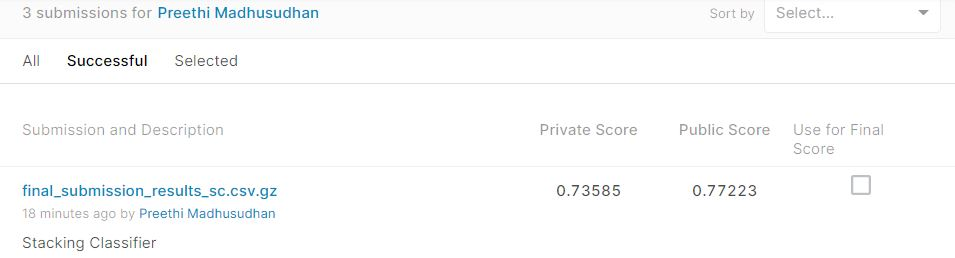

This score can be further tried to be improved. Hence, choosing the next best model - the LGBM. 

###Using LGBM Model

In [ ]:
test_model=joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/final_model_lgbm.pkl')
print('The saved model has been loaded to verify with the test data set')

The saved model has been loaded to verify with the test data set


In [ ]:
#Using dask to read pre-processed test data from the drive. 
#There are 173 partitions in the dask dataframe
#Read each partition and predict the results for each partition.


a_class_probs = []
b_class_probs=[]
c__class_probs=[]
d_class_probs = []

for i in range(0,173):

  test_df_part = test_df.partitions[i].compute()
  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 

  test_results = test_model.predict_proba(test_df_part)
  a_class_probs.extend((test_results[:,0]).tolist())
  b_class_probs.extend((test_results[:,1]).tolist())
  c__class_probs.extend((test_results[:,2]).tolist())
  d_class_probs.extend((test_results[:,3]).tolist())
  
  print(i,test_df_part.shape,test_results.shape)

0 (105160, 89) (105160, 4)
1 (105387, 89) (105387, 4)
2 (106101, 89) (106101, 4)
3 (106618, 89) (106618, 4)
4 (103620, 89) (103620, 4)
5 (103246, 89) (103246, 4)
6 (104830, 89) (104830, 4)
7 (103315, 89) (103315, 4)
8 (103429, 89) (103429, 4)
9 (103703, 89) (103703, 4)
10 (103772, 89) (103772, 4)
11 (103036, 89) (103036, 4)
12 (104580, 89) (104580, 4)
13 (105063, 89) (105063, 4)
14 (100769, 89) (100769, 4)
15 (104133, 89) (104133, 4)
16 (104076, 89) (104076, 4)
17 (102887, 89) (102887, 4)
18 (105457, 89) (105457, 4)
19 (106642, 89) (106642, 4)
20 (104984, 89) (104984, 4)
21 (105303, 89) (105303, 4)
22 (105484, 89) (105484, 4)
23 (105778, 89) (105778, 4)
24 (102828, 89) (102828, 4)
25 (103057, 89) (103057, 4)
26 (104848, 89) (104848, 4)
27 (102832, 89) (102832, 4)
28 (103929, 89) (103929, 4)
29 (103533, 89) (103533, 4)
30 (104111, 89) (104111, 4)
31 (103176, 89) (103176, 4)
32 (105273, 89) (105273, 4)
33 (104625, 89) (104625, 4)
34 (100974, 89) (100974, 4)
35 (103580, 89) (103580, 4)
36

In [ ]:
#Create a dataframe to store the results in the Kaggle prescribed format.
submission_results=pd.DataFrame()

submission_results["id"]=np.arange(0,17965143)
submission_results["A"]=a_class_probs
submission_results["B"]=b_class_probs
submission_results["C"]=c__class_probs
submission_results["D"]=d_class_probs
submission_results


,id,A,B,C,D
0,0,0.996139,0.000085,0.000452,0.003324
1,1,0.994638,0.000032,0.004562,0.000768
2,2,0.998559,0.000027,0.000814,0.000600
3,3,0.981018,0.000049,0.017764,0.001168
4,4,0.993694,0.000078,0.005575,0.000653
...,...,...,...,...,...
17965138,17965138,0.073725,0.000030,0.925011,0.001234
17965139,17965139,0.626726,0.000215,0.370565,0.002494
17965140,17965140,0.025675,0.000024,0.974017,0.000284
17965141,17965141,0.235651,0.000155,0.761877,0.002317


In [ ]:
#Remove the index column
submission_results=submission_results.sort_values(by=['id'])
submission_results.reset_index(inplace = True) 
submission_results=submission_results.drop('index',axis=1)
submission_results.head()

,id,A,B,C,D
0,0,0.996139,0.000085,0.000452,0.003324
1,1,0.994638,0.000032,0.004562,0.000768
2,2,0.998559,0.000027,0.000814,0.000600
3,3,0.981018,0.000049,0.017764,0.001168
4,4,0.993694,0.000078,0.005575,0.000653


In [ ]:
#Save the results in compressed format so it can be uploaded to Kaggle
submission_results.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_submission_results.csv.gz',index=False, compression='gzip')

##The Final Score

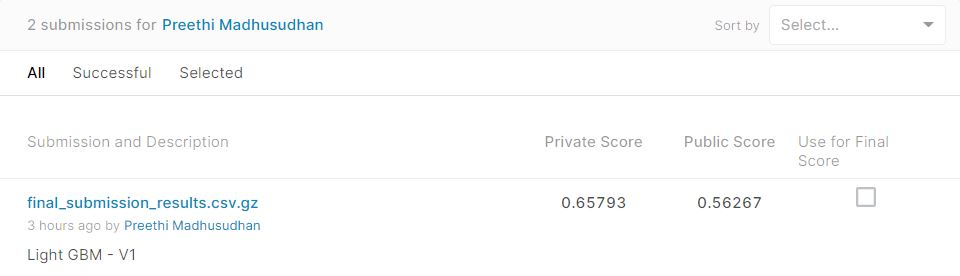

The score obtained in Kaggle for the test data using the LGBM model has given a better result. Hence, we can say that the LGBM model is better suited for this ML problem.

In [ ]:

eeg_feature_names = ["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"]

def pre_process(test_df):

	#Pre-processing the data - START
	denoised_r = denoise(0.05,test_df["r"],5) 
	test_df['denoised_r'] = denoised_r

	denoised_ecg = denoise(0.05,test_df["ecg"],5) 
	test_df['denoised_ecg'] = denoised_ecg

	resp_rate_op = resp.resp(test_df['denoised_r'],sampling_rate=256, show=False)
	resp_rate_arr = interpolation_fn(test_df["time"],resp_rate_op['resp_rate_ts'],resp_rate_op['resp_rate'])
	test_df['r_rate'] =resp_rate_arr
	
	heart_rate_op = ecg.ecg(signal=test_df['denoised_ecg'], sampling_rate=256, show=False)
	heart_rate_arr = interpolation_fn(test_df["time"],heart_rate_op['heart_rate_ts'],heart_rate_op['heart_rate'])
	test_df['heart_rate'] =heart_rate_arr
	
	test_df['fp1_f7'] = test_df['eeg_fp1'] - test_df['eeg_f7']
	test_df['f7_t3'] = test_df['eeg_f7'] - test_df['eeg_t3']
	test_df['t3_t5'] = test_df['eeg_t3'] - test_df['eeg_t5']
	test_df['t5_o1'] = test_df['eeg_t5'] - test_df['eeg_o1']
	test_df['fp1_f3'] = test_df['eeg_fp1'] - test_df['eeg_f7']
	test_df['f3_c3'] = test_df['eeg_f3'] - test_df['eeg_c3']
	test_df['c3_p3'] = test_df['eeg_c3'] - test_df['eeg_p3']
	test_df['p3_o1'] = test_df['eeg_p3'] - test_df['eeg_o1']

	test_df['fz_cz'] = test_df['eeg_fz'] - test_df['eeg_cz']
	test_df['cz_pz'] = test_df['eeg_cz'] - test_df['eeg_pz']
	test_df['pz_poz'] = test_df['eeg_pz'] - test_df['eeg_poz']

	test_df['fp2_f8'] = test_df['eeg_fp2'] - test_df['eeg_f8']
	test_df['f8_t4'] = test_df['eeg_f8'] - test_df['eeg_t4']
	test_df['t4_t6'] = test_df['eeg_t4'] - test_df['eeg_t6']
	test_df['t6_o2'] = test_df['eeg_t6'] - test_df['eeg_o2']
	test_df['fp2_f4'] = test_df['eeg_fp2'] - test_df['eeg_f4']
	test_df['f4_c4'] = test_df['eeg_f4'] - test_df['eeg_c4']
	test_df['c4_p4'] = test_df['eeg_c4'] - test_df['eeg_p4']
	test_df['p4_o2'] = test_df['eeg_p4'] - test_df['eeg_o2']
	
	
	eeg_freq_arr = eeg.get_power_features(test_df[eeg_feature_names],sampling_rate=256)
	get_eeg_features('theta',20,test_df,eeg_freq_arr['ts'],eeg_freq_arr['theta'])
	get_eeg_features('alpha_low',20,test_df,eeg_freq_arr['ts'],eeg_freq_arr['alpha_low'])
	get_eeg_features('alpha_high',20,test_df,eeg_freq_arr['ts'],eeg_freq_arr['alpha_high'])
	
	
	gsr_mean = test_df['gsr'].rolling(window=4,min_periods=1).mean()
	gsr_max = test_df['gsr'].rolling(window=4,min_periods=1).max()
	gsr_min = test_df['gsr'].rolling(window=4,min_periods=1).min()

	gsr_min_max = gsr_max - gsr_min

	test_df['gsr_mean'] = gsr_mean
	test_df['gsr_min_max'] = gsr_min_max
	test_df = reduce_mem_usage(test_df)
	
	test_df.drop(["eeg_fp1", "eeg_f7", "eeg_f8", "eeg_t4", "eeg_t6", 
                "eeg_t5", "eeg_t3", "eeg_fp2", "eeg_o1", "eeg_p3", 
                "eeg_pz", "eeg_f3", "eeg_fz", "eeg_f4", "eeg_c4", 
                "eeg_p4", "eeg_poz", "eeg_c3", "eeg_cz", "eeg_o2"],inplace=True,axis=1)
	test_df.drop(['experiment','ecg','r','id','Unnamed: 0'],inplace=True,axis = 1)
	
	test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_testdata.csv')
	#Pre-processing the data - END



In [ ]:
def pre_process_and_predict(test_df):
	
	pre_process(test_df)
	
	#Load the Best Model - LGBM
	
	test_df = dd.read_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_testdata.csv')
	#Find the number of partititions
	no_partitions = test_df.npartitions 
	
	
	#Load the model
	test_model=joblib.load('/content/drive/MyDrive/Colab Notebooks/Aviation/final_model_lgbm.pkl')
	
	
	a_class_probs = []
	b_class_probs=[]
	c__class_probs=[]
	d_class_probs = []

	for i in range(0,no_partitions):

	  test_df_part = test_df.partitions[i].compute()
	  test_df_part.drop(['Unnamed: 0'],inplace=True,axis=1) 

	  test_results = test_model.predict_proba(test_df_part)
	  a_class_probs.extend((test_results[:,0]).tolist())
	  b_class_probs.extend((test_results[:,1]).tolist())
	  c__class_probs.extend((test_results[:,2]).tolist())
	  d_class_probs.extend((test_results[:,3]).tolist())
  
	  print(i,test_df_part.shape,test_results.shape)
	  
	  submission_results=pd.DataFrame()

	  submission_results["id"]=np.arange(0,17965143)
	  submission_results["A"]=a_class_probs
	  submission_results["B"]=b_class_probs
	  submission_results["C"]=c__class_probs
	  submission_results["D"]=d_class_probs
	  
	  submission_results=submission_results.sort_values(by=['id'])
	  submission_results.reset_index(inplace = True) 
	  submission_results=submission_results.drop('index',axis=1)
	  submission_results.head()
	  
	  submission_results.to_csv('/content/drive/MyDrive/Colab Notebooks/Aviation/final_submission_results.csv.gz',index=False, compression='gzip')
	     
   return submission_results

In [ ]:
def pre_process_and_predictWithTarget(test_df,y_test):
	
	test_predictions = pre_process_and_predict(test_df)
	
	logloss = log_loss(y_test,test_predictions))